# Time Series Analysis with Back Testing 

## Loading Dataset

In [1]:
## Laading libraries
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loading dataset
def getData(strt_date, end_date):
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Days"] = range(1,df.shape[0]+1)
    
    return df

In [3]:
## User input, can be changed
strt_date = "2019-01-01"
end_date = "2019-12-31"

## final dataset
main_df = getData(strt_date, end_date)
main_df.shape

(252, 25)

## Data Modification as per requirements

In [4]:
df_x = main_df.drop("Open", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = main_df[["Open"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df.head()

,Date,High,Low,Close,Volume,Adj Close,Mkt-RF,SMB,HML,RMW,...,HC- Close,S&P 500-Open,S&P500-High,S&P-Low,S&P-Close,S&P500-Adj Close,S&P500-Volume,ADS-Index,Days,Open
0,2019-01-02,91.389999,89.930000,91.279999,9843900.0,88.258690,0.23,0.73,1.15,-0.13,...,2510.03,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3.733160e+09,0.154689,1.0,90.940002
1,2019-01-03,92.500000,90.379997,90.639999,9820200.0,87.639870,-2.45,0.52,1.23,-0.25,...,2447.89,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3.822860e+09,0.143820,2.0,90.839996
2,2019-01-04,92.489998,90.370003,92.489998,10565700.0,89.428635,3.55,0.39,-0.74,-0.09,...,2531.94,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09,0.132721,3.0,91.910004
3,2019-01-07,92.500000,91.400002,92.120003,9012500.0,89.070892,0.94,0.82,-0.67,-0.70,...,2549.69,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4.104710e+09,0.121334,4.0,92.699997
4,2019-01-08,93.089996,91.820000,92.459999,9551300.0,89.399635,1.01,0.44,-0.53,0.35,...,2574.41,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4.083030e+09,0.109397,5.0,92.690002


## Time Series Format

Date
2019-01-02     90.940002
2019-01-03     90.839996
2019-01-04     91.910004
2019-01-07     92.699997
2019-01-08     92.690002
                 ...    
2019-12-23    124.790001
2019-12-24    125.099999
2019-12-26    125.559998
2019-12-27    125.760002
2019-12-30    124.430000
Name: Open, Length: 251, dtype: float64


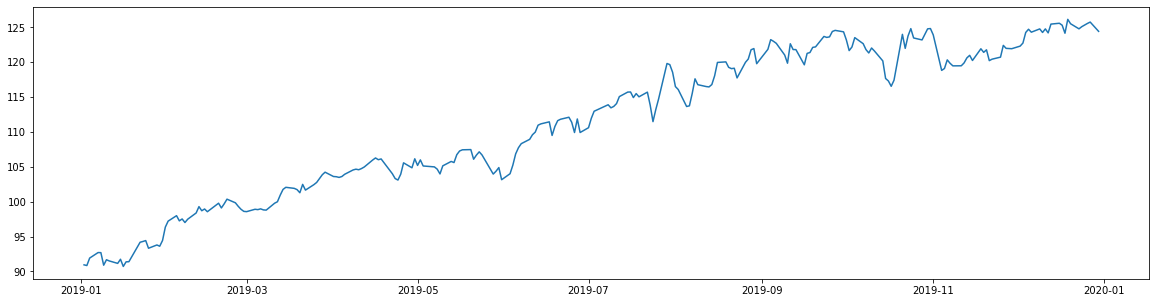

In [5]:
ts = modified_df[["Date","Open"]]
ts = ts.set_index("Date")
ts = ts.squeeze()

print(ts)

plt.figure(figsize=(20,5))
plt.plot(ts)

## Checking the Stationarity of the time series

In [6]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

<Figure size 1440x360 with 0 Axes>

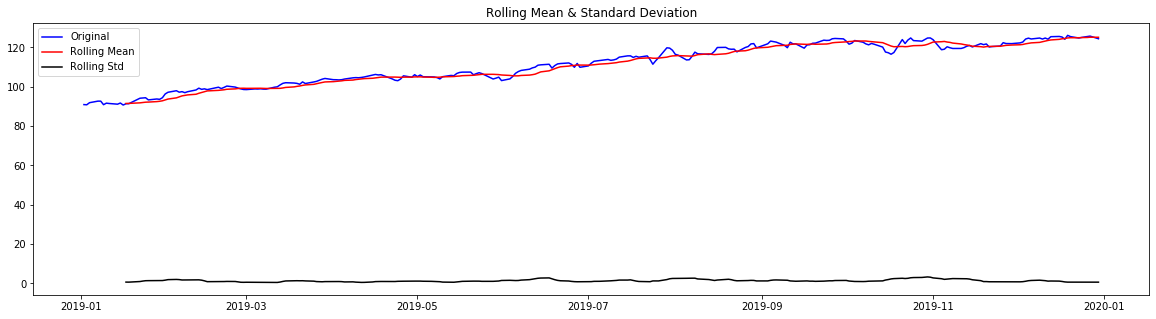

Results of Dickey-Fuller Test:
Test Statistic                  -1.963143
p-value                          0.302964
#Lags Used                      10.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [7]:
plt.figure(figsize=(20,5))
test_stationarity(ts)

## Estimating & Eliminating Trend

### Log Transformation

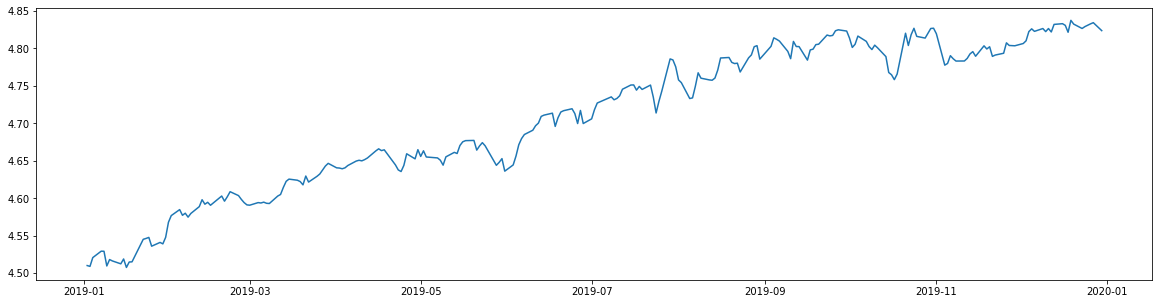

In [8]:
plt.figure(figsize=(20,5))
ts_log = np.log(ts)
plt.plot(ts_log)

### Moving Average

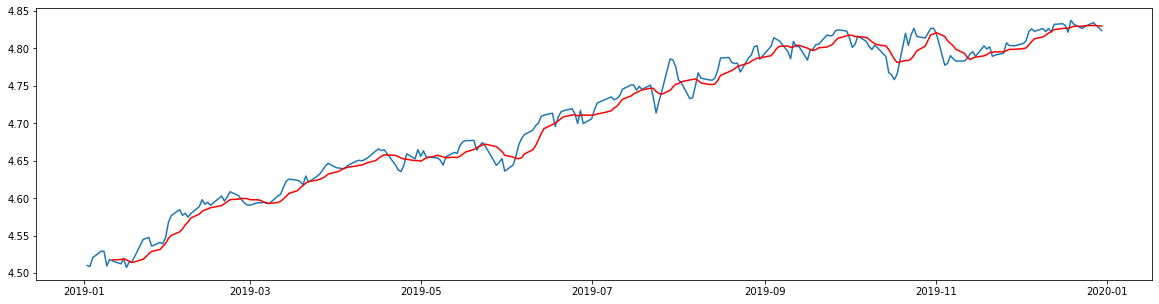

In [9]:
plt.figure(figsize=(20,5))
moving_avg = ts_log.rolling(window=8).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

<Figure size 1440x360 with 0 Axes>

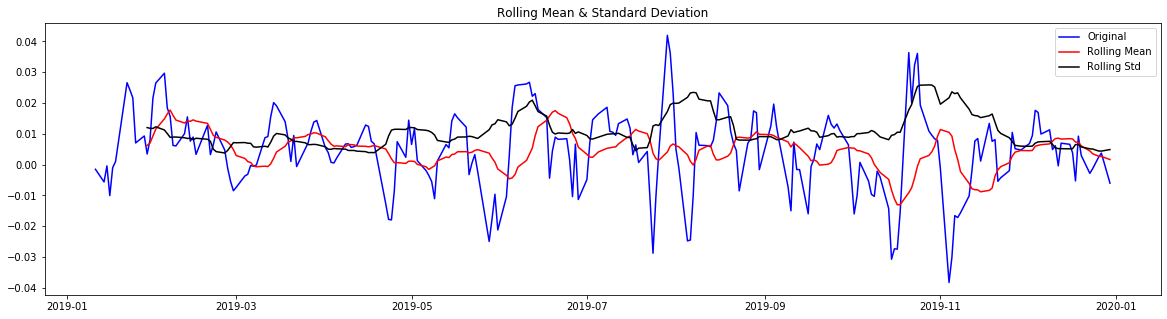

Results of Dickey-Fuller Test:
Test Statistic                -7.639155e+00
p-value                        1.916440e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


In [10]:
plt.figure(figsize=(20,5))
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Exponentially Weighted Moving Average

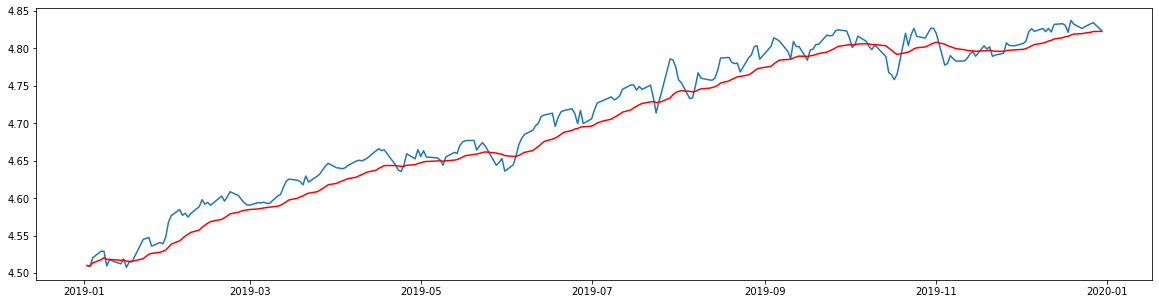

In [11]:
plt.figure(figsize=(20,5))
expwighted_avg = ts_log.ewm(halflife=8).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

<Figure size 1440x360 with 0 Axes>

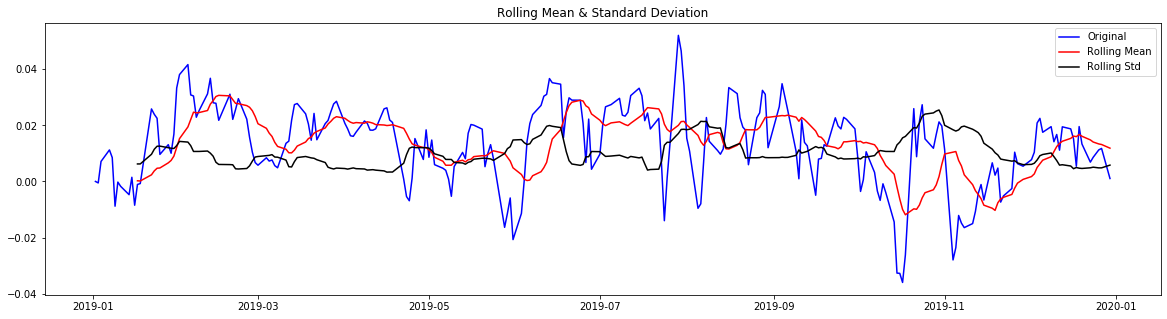

Results of Dickey-Fuller Test:
Test Statistic                  -5.499159
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [12]:
plt.figure(figsize=(20,5))
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

### First Order Differencing

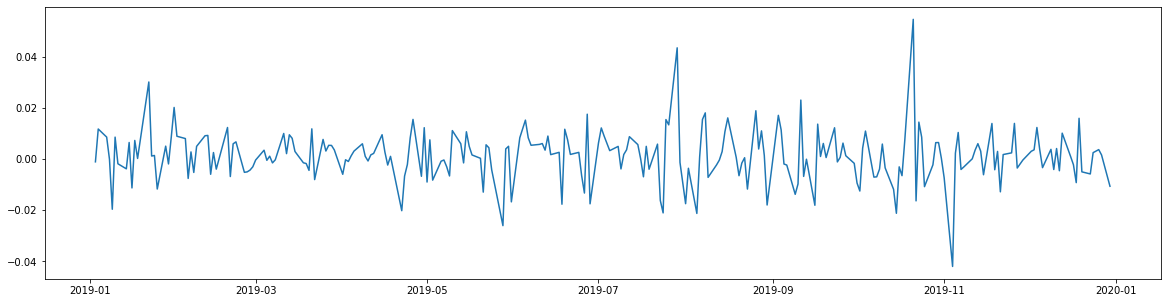

In [13]:
plt.figure(figsize=(20,5))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

<Figure size 1440x360 with 0 Axes>

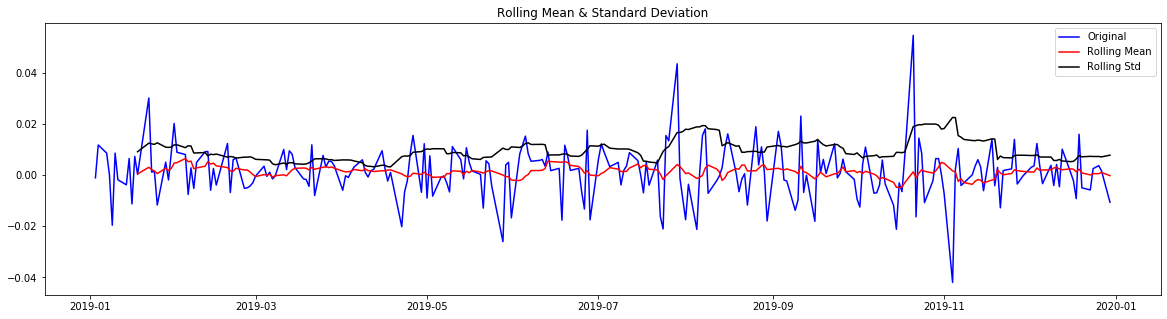

Results of Dickey-Fuller Test:
Test Statistic                -7.018561e+00
p-value                        6.634257e-10
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


In [14]:
plt.figure(figsize=(20,5))
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposing

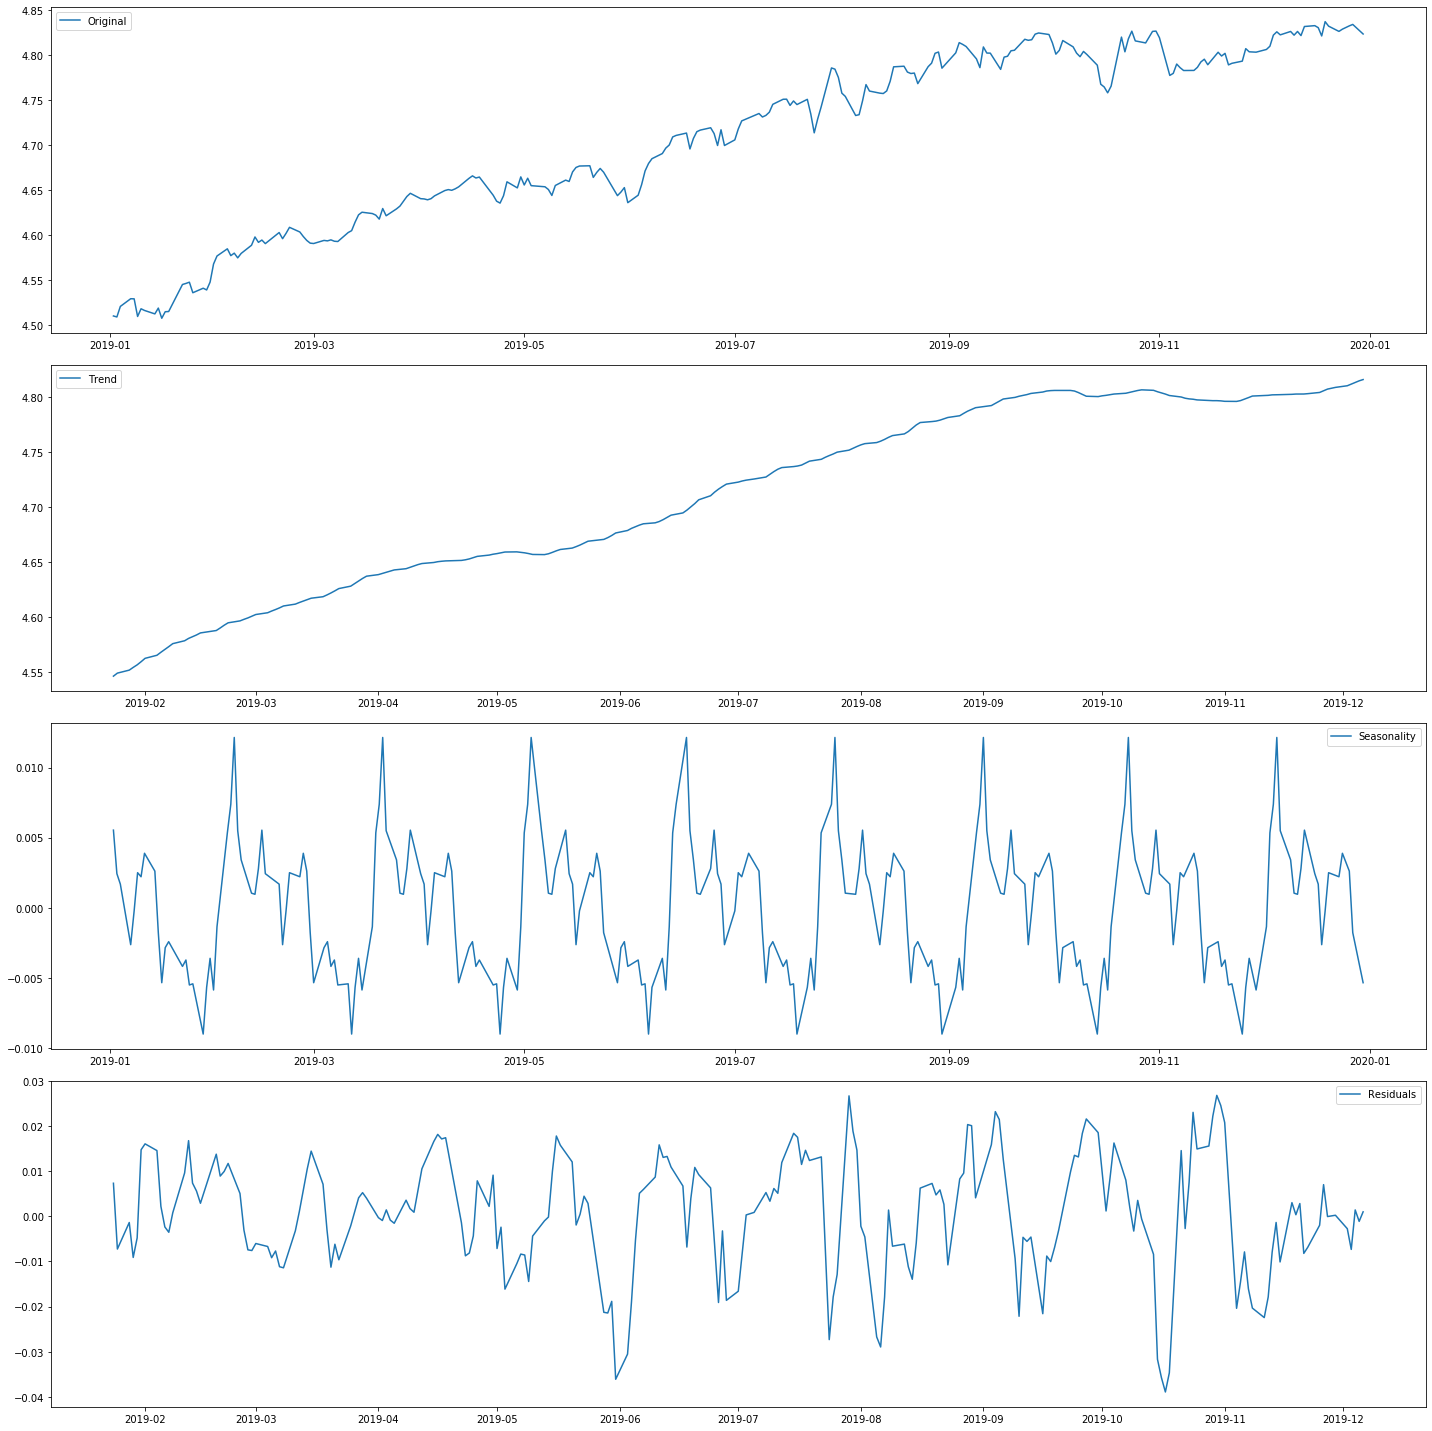

In [15]:
decomposition = seasonal_decompose(ts_log,freq=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<Figure size 1440x360 with 0 Axes>

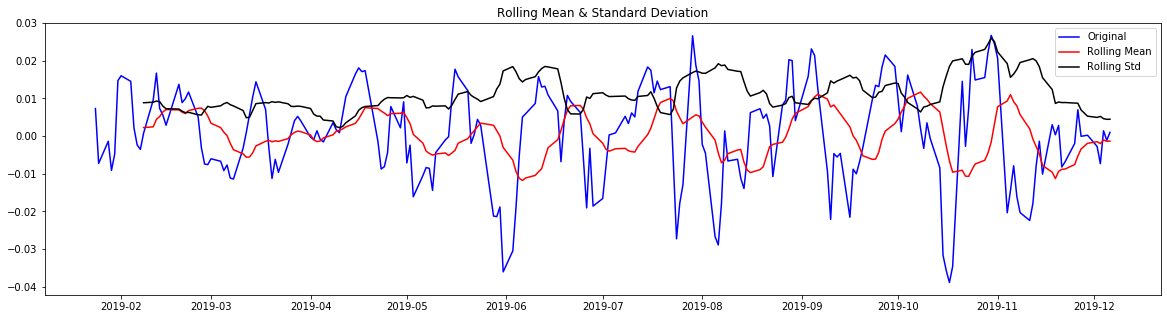

Results of Dickey-Fuller Test:
Test Statistic                -7.155584e+00
p-value                        3.060871e-10
#Lags Used                     9.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


In [16]:
plt.figure(figsize=(20,5))
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecasting a Time Series

### Partial auto correlation function (PACF) and Auto correlation function (ACF) (Estimating the parameter p and q in ARIMA model)

In [17]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

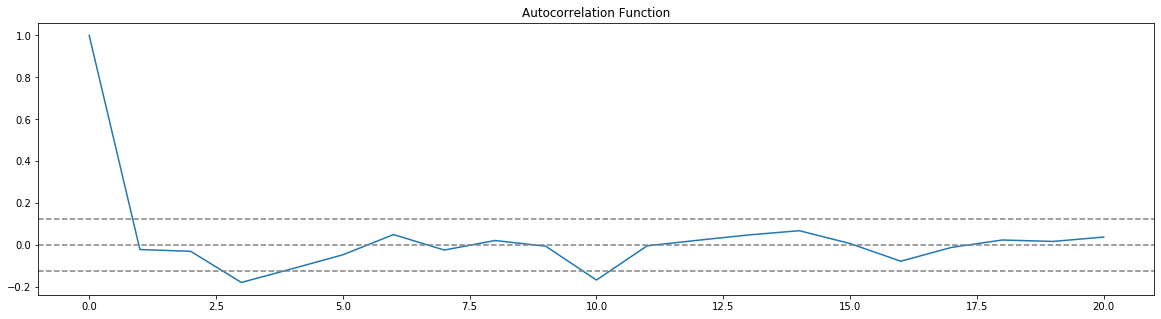

In [18]:
#Plot ACF:
plt.figure(figsize=(20,5))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

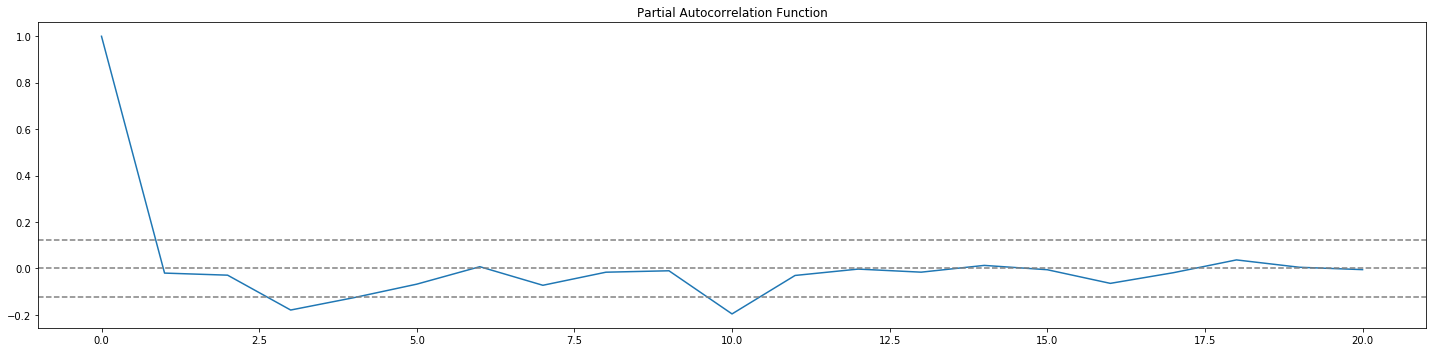

In [19]:
#Plot PACF:
plt.figure(figsize=(20,5))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Grid Search to find the best Arima Model Order (p,d,q)

In [20]:
def evaluate_arima_model(train_data, test_data, arima_order):
    history = [x for x in train_data]
    predictions = list()
    for t in range(len(test_data)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
#         print(predictions)
        history.append(test_data[t])
    error = mean_squared_error(test_data, predictions)
    
    return [error, predictions]

In [21]:
def evaluate_models(train_data, test_data, p_values, d_values, q_values):
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))
    for x in pdq:
        print('p=',x[0],'d=',x[1],'q=',x[2])
        order = (x[0],x[1],x[2])
        try:
            mse, pred = evaluate_arima_model(train_data, test_data, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.10f' % (order,mse))
        except:
            continue

    print('Best ARIMA%s MSE=%.10f' % (best_cfg, best_score))

In [22]:
train_data, test_data = ts_log[:int(len(ts_log)*0.923)], ts_log[int(len(ts_log)*0.923):]
p_values = range(0,3)
d_values = [1]
q_values = range(0,3)
evaluate_models(train_data, test_data, p_values, d_values, q_values)

p= 0 d= 1 q= 0
ARIMA(0, 1, 0) MSE=0.0000445868
p= 0 d= 1 q= 1
ARIMA(0, 1, 1) MSE=0.0000442659
p= 0 d= 1 q= 2
ARIMA(0, 1, 2) MSE=0.0000433803
p= 1 d= 1 q= 0
p= 1 d= 1 q= 1
p= 1 d= 1 q= 2
p= 2 d= 1 q= 0
p= 2 d= 1 q= 1
ARIMA(2, 1, 1) MSE=0.0000427658
p= 2 d= 1 q= 2
Best ARIMA(2, 1, 1) MSE=0.0000427658


Text(0.5, 1.0, 'RSS: 0.0243')

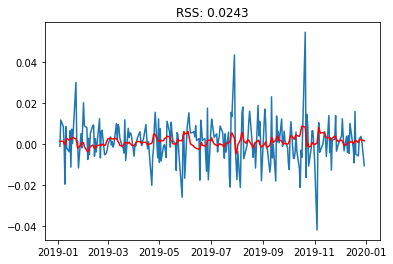

In [23]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=0)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

## Model Prediction

In [24]:
def df_pred(test_data, pred):
    test_data = pd.DataFrame(test_data).reset_index(drop=True)
    pred = pd.DataFrame(pred, columns=["Y_PRED"]).reset_index(drop=True)
    pred_df = pd.concat([test_data, pred], axis=1)
    pred_df = pred_df.rename(columns={"Open": "Y_ACT"})
    
    return pred_df

In [25]:
mse, pred = evaluate_arima_model(train_data, test_data, arima_order=(2,1,1))
predictions_ARIMA = np.exp(pred)
main_test_df = modified_df[int(len(main_df)*0.920):]
actual_open = main_test_df[["Open"]]
pred_df = df_pred(actual_open, predictions_ARIMA)
pred_df.head()

,Y_ACT,Y_PRED
0,122.309998,122.147644
1,122.750000,122.522675
2,124.269997,122.919205
3,124.730003,124.345355
4,124.309998,124.659458


## Accuracy Testing

In [26]:
def residual_variance(df):
    error = list(df["ERROR"])
    SSE = sum(map(lambda i : i * i, error)) 
    
    return SSE    

In [27]:
def totalError_Square(df):
    y_act = df['Y_ACT']
    n = len(df["Y_ACT"])
    y_mean = sum(df["Y_ACT"])/n
    res = list(y_act - y_mean)
    SST = sum(map(lambda i : i * i, res))
    
    return SST

In [28]:
def R_squared(df):
    error = list(df["ERROR"])
    SSE = residual_variance(df)
    SST = totalError_Square(df)
    r2 = 1 - float(SSE/SST)
    
    return r2 

In [29]:
def rmse_value(df):
    error = list(df["ERROR"])
    SSE = residual_variance(df)
    n = len(error)
    rmse = sqrt(SSE/n)
    
    return rmse

In [30]:
def error_cal(df):
    df["ERROR"] = df["Y_PRED"] - df["Y_ACT"]
    
    return df

In [31]:
def accuracy(df):
    acc = list()
    pred_df = error_cal(df)
    r_sq = R_squared(df)
    rmse = rmse_value(df)
    acc.append(r_sq)
    acc.append(rmse)
    
    return acc

In [32]:
acc = accuracy(pred_df) 
print("R_2 Value: ", acc[0])
print("RMSE Value: ", acc[1])

R_2 Value:  0.225362818678158
RMSE Value:  0.8165587818642354


## Visualisation Plot

In [33]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

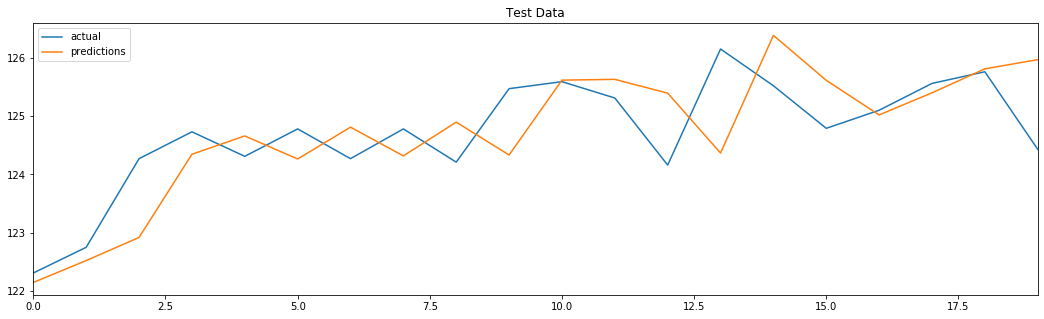

In [34]:
create_plot(list(pred_df["Y_PRED"]), list(pred_df["Y_ACT"]), title="Test Data")

## Back Testing 

In [35]:
def backtesting_df(main_data, pred_data):
    backtesting_df = pd.concat([main_data[["Date","Open","Close","S&P 500-Open","S&P-Close","High"]].reset_index(drop=True),pred_data["Y_PRED"]], axis=1)
    backtesting_df = backtesting_df.rename(columns={"Date": "Date", "Open": "R_Open", "High": "R_High", "Close": "R_Close","S&P 500-Open": "SP_Open","S&P-Close": "SP_Close","Y_PRED": "P_Open"})
    
    return backtesting_df

In [36]:
def back_test(df_backtest):
    df = df_backtest.copy()
    conditions = [(df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) < df['R_High'].shift(-1)),
                  (df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) > df['R_High'].shift(-1))]
    choices = [(df['P_Open'].shift(-1) - df['R_Close'])*100/df['R_Close'], 
               (df['R_High'].shift(-1) - df['R_Close'])*100/df['R_Close']]
    #Ra : Portfolio's Return
    df['Ra'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              np.select(conditions, choices, default=np.nan),
                              np.nan)
    #Riskfree return (S&P500 return)
    df['Rb'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              (df['SP_Open'].shift(-1) - df['SP_Close'])*100/df['SP_Close'],
                              np.nan)
    df = df.dropna()
    #Sharpe ratio
    Sharpe = (df['Ra'] - df['Rb']).mean() / (df['Ra'] - df['Rb']).std()
    beta = ((df[['Ra','Rb']]).cov()).Rb[0] / df['Rb'].var()
    #Treynor ratio
    Treynor  = (df['Ra'] - df['Rb']).mean() / beta    
    #average profit
    profit = df['Ra'].mean()
    #hitrate
    Hitrate = df[df['Ra'] > 0]['Ra'].count() / df['Ra'].count()
    
    return Sharpe, Treynor, profit, Hitrate

In [37]:
back_test_df = backtesting_df(main_test_df, pred_df)
[sharpe_ratio, treynor_ratio, avg_profit, hitrate] = back_test(back_test_df)

print("Backtesting results are given below: ")
print(" 1. Sharpe Ratio is: ", round(sharpe_ratio,2))
print(" 2. Treynor Ratio is: ", round(treynor_ratio,2))
print(" 3. Average Profit is: ", round(avg_profit*100,2), "%")
print(" 4. Hit Rate is: ", round(hitrate,2))

Backtesting results are given below: 
 1. Sharpe Ratio is:  0.05
 2. Treynor Ratio is:  0.03
 3. Average Profit is:  28.8 %
 4. Hit Rate is:  1.0
